In [1]:
'''
Capstone Roadmap:

This is where I got the dataset > http://www.idiap.ch/resource/gestures/
For a direct link to the Marcel data > http://www.idiap.ch/resource/gestures/data/dhp_marcel.tar.gz

MVP     - Image classifier for B
MVP+1   - Image Classifier for A, B, C, Five, Point
MVP_ASL - Image Classifier for A, B, C, D, E... Z
Proto   - Image Classifier for simple dictionary words
Proto + second hand
Proto + body
Product - Video image Classifer <> GoPro, Kinect
Final   - Works in an 'Google Translator' App
'''
print('')

In [2]:
import os, glob, cv2, random, re, keras, tensorflow, itertools
import numpy as np
import pandas as pd
import skimage.io as skio
import skimage.transform as skt
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from IPython.core.interactiveshell import InteractiveShell
from sklearn.cross_validation import train_test_split, cross_val_score

%matplotlib inline

Using TensorFlow backend.
/Users/njume/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [4]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, consensus_score, roc_auc_score, roc_curve, auc

In [5]:
'''
collecting all data locations into lists
<> replace with code to check ./input for images, add to data
'''

part_five  = [image for image in glob.glob('../Daka/ALS_translator/Marcel-Train/Five/*')]
part_a     = [image for image in glob.glob('../Daka/ALS_translator/Marcel-Train/A/*')]
part_b     = [image for image in glob.glob('../Daka/ALS_translator/Marcel-Train/B/*')]
part_point = [image for image in glob.glob('../Daka/ALS_translator/Marcel-Train/Point/*')]
part_c     = [image for image in glob.glob('../Daka/ALS_translator/Marcel-Train/C/*')]


## What does the dataset looklike?

When working with images I can't just look at corrilations/plots and come up with a target related to what I am looking for. I need good data. And a good question. We see that the classes are unbalanced, but for our purposes since this is a classification I don't see this being a big factor.

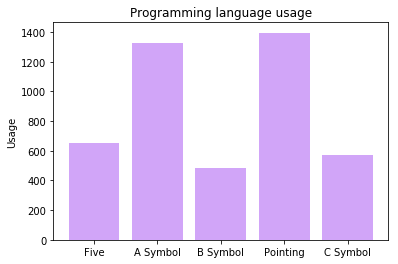

In [6]:
objects = ('Five', 'A Symbol', 'B Symbol', 'Pointing', 'C Symbol')
y_pos = np.arange(len(objects))
performance = [len(part_five),len(part_a),len(part_b),len(part_point),len(part_c)]
 
plt.bar(y_pos, performance, align='center', alpha=0.5, color='#A54CF3')
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')
 
plt.show()

In [7]:
'''
concating data locations into one list
'''

full = [part_a, part_b, part_c, part_point, part_five]
image_paths= []
for dataset in full:
    image_paths.extend(dataset)
    
'''sanity check'''
image_paths[1], image_paths[2001]

('../Daka/ALS_translator/Marcel-Train/A/A-train0910.ppm',
 '../Daka/ALS_translator/Marcel-Train/C/C-train521.ppm')

/Users/njume/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/njume/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


((64, 64), (64, 64, 1))

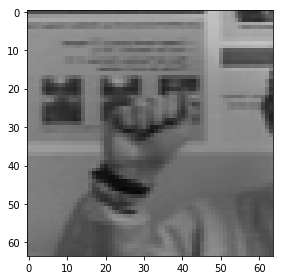

In [8]:
'''length X width X channel (64,64, 1) does not work with skimage, it breaks plt'''
first_pic_sk = skio.imread(image_paths[0], as_grey=True)
first_pic_skt = skt.resize(first_pic_sk,(64,64,1))
# skio.imshow(first_pic_skt)

first_pic_sk2 = skt.resize(first_pic_sk,(64, 64))
skio.imshow(first_pic_sk2)
first_pic_sk2.shape, first_pic_skt.shape

/Users/njume/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


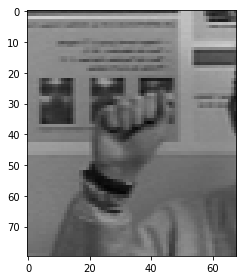

In [9]:
skio.imshow(first_pic_sk)

In [10]:
'''
working image size will be 64x64
'''

all_images = []
largest = 0,0
for image in image_paths:
    img = skio.imread(image, as_grey=True)
    img = img.astype('float32')
    img = skt.resize(img,(64, 64))
    all_images.append(img)
    
    '''sanity check'''
    if img.shape > largest:
        largest = img.shape
        print(image)
        print(largest)
        
converted_X = np.array(all_images)

/Users/njume/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


../Daka/ALS_translator/Marcel-Train/A/A-train0904.ppm
(64, 64)


In [11]:
'''COMPARISON PURPOSES. REMEMBER IT READS IMAGES AS BGR NOT RGB,
the quality of the photo is the same when reshaped'''
# cv_image = cv2.imread(image_paths[0], 0)
# cv_image = cv2.resize(cv_image, (32,32))
# plt.imshow(cv_image)

'COMPARISON PURPOSES. REMEMBER IT READS IMAGES AS BGR NOT RGB,\nthe quality of the photo is the same when reshaped'

In [12]:
 '''Setting y target'''
target     = []

for path in image_paths:
    if re.search((r'\/input\/Marcel-Train\/B'), path) != None:
        target.append(1)
    else:
        target.append(0)

'''cant figure out list coprehension or lambda for this'''
# [c if re.search((r'\/input\/Marcel-Train\/B') == None, path) for path in image_paths]        
# <>forloop<>target.append(lambda x: 0 if path != None else 1)

'''Sanity Check'''
_ = pd.DataFrame(target)
_[0].value_counts()

0    4437
Name: 0, dtype: int64

In [13]:
'''Setting X, y'''
y = target
X = converted_X

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)
X_train[0]    # this is one image
X_train[0][0] # this is one row of that image

array([0.63036208, 0.68160849, 0.67820823, 0.67922327, 0.68130169,
       0.68204226, 0.68307401, 0.68279279, 0.6794581 , 0.73939067,
       0.81633397, 0.81777234, 0.81406043, 0.81209701, 0.8070717 ,
       0.80752013, 0.81268203, 0.8145789 , 0.80813815, 0.81237529,
       0.8079577 , 0.81371909, 0.81751906, 0.81697158, 0.81607751,
       0.81627207, 0.81879526, 0.81699575, 0.81963645, 0.82212946,
       0.82233254, 0.81905802, 0.81843743, 0.82030658, 0.82109948,
       0.82276477, 0.81885389, 0.81289864, 0.81608426, 0.8200479 ,
       0.81972491, 0.82215292, 0.81813819, 0.81832665, 0.82173929,
       0.82349631, 0.82372191, 0.82478028, 0.82391763, 0.82077365,
       0.81711133, 0.81770908, 0.82112574, 0.82442005, 0.8262463 ,
       0.8279681 , 0.82734488, 0.82482802, 0.82515871, 0.82714025,
       0.82795884, 0.82820011, 0.82613251, 0.82793391])

## Personally I like to check whether or not I have over shrunk my images.

### I stick the a degree that I can still make out the picture when I am working with a small dataset. We can check this with matplotlib.
##### but it's not just that easy.

(64, 64)

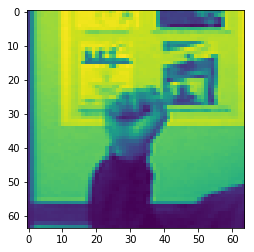

In [14]:
'''sanity check'''
plt.imshow(X_train[5])
X_train[5].shape

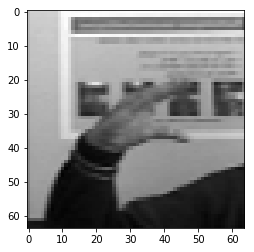

In [15]:
'''Turns out matplot lib doesn"t like gray images, hmm...'''
plt.imshow(X_train[0],cmap=plt.get_cmap('gray'))

## Upcoming code sneak peak:
#### This code is imported from <a href="https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html">this site</a> it deals with orentation and limited datasets.

In [16]:

'''from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=True,
        fill_mode='nearest')

# img = load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
# x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
# x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
X_train.reshape((1,)+ X_train.shape)
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(X_train, batch_size=1,save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 10:
        break  # otherwise the generator would loop indefinitely
def image_gen(batch_size, y_dict, path):
    directory = os.listdir(path=path)
    Xout = []
    yout = []
    counter = 0
    for filename in it.cycle(directory):
        if '.jpg' in filename:
            try:
                yout.append(y_dict[filename])
                img=cv2.imread(path + filename)
                img = img/255
                img.reshape(1,400,640,3)
                Xout.append(img)
                counter += 1
                if counter % batch_size == 0:
                    yield (np.array(Xout), np.array(yout))#np.random.randint(2, size=batch_size))
                    Xout = []
                    yout= []
            except:
                continue'''
print('')

##### Another Sanity check ~

In [17]:
X_train.max(), X_train.min(), X_test.max(), X_test.min()

(0.9960784316062927, 0.0, 0.9960784316062927, 0.0)

In [35]:
X_train.shape

(3105, 64, 64, 1)

## Alright lets put the data to the grinder, and file it down in a neural network.

#### I have chosen a Convelutional Neural Network because I need to read images in a way that the computer can seperate what is and isnt my target. It does this by puting every pixel into an array of numbers that represent the colors its giving off.

While my images are small and I did reduce their pixel count, each pixel is still far to big to be digested by a simple macbook in a timely fashion. To solve this we pool similar boxes together and reduce the image to an easier format.

In [19]:
'''nn imported from lesson'''
model = Sequential()
model.add(Conv2D(filters = 6, 
                 kernel_size= 3, 
                 activation='relu', 
                 input_shape=(64, 64, 1)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(filters = 16,
                 kernel_size= 3,
                 activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [20]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

Now I need to make all my images in X_train the same size so that it will read properly in the NN. The 1 in (64,64,1) is there because these images have been grayscaled. Don't let matplotlib's default print settings fool you into thinking that the images are in RGB.

In [21]:
X_train = X_train.reshape(X_train.shape[0],64,64,1)
X_test = X_test.reshape(X_test.shape[0],64,64,1)

Now that the model has been completely setup, and my images are all the same size we are ready to train the model on the data. We can see with simpilier solutions not having 1000s of images to train on is not that big of a deal.
The strength of this model is within the small varience between images, as they are all pictures of hands doing similar things. 

I believe CNN gets a lot harder when your dataset is pictures of things that look nothing alike. In this case the NN can tell that there is a hand in every image.

In [22]:
model.fit(X_train, y_train,
          batch_size=32, epochs=30)

Epoch 1/30
3105/3105 [==============================] - 3s 893us/step - loss: 0.0115 - acc: 0.9987
Epoch 2/30
3105/3105 [==============================] - 2s 781us/step - loss: 1.1362e-07 - acc: 1.0000
Epoch 3/30
3105/3105 [==============================] - 3s 816us/step - loss: 1.1733e-07 - acc: 1.0000
Epoch 4/30
3105/3105 [==============================] - 3s 817us/step - loss: 1.0427e-07 - acc: 1.0000
Epoch 5/30
3105/3105 [==============================] - 3s 819us/step - loss: 1.0778e-07 - acc: 1.0000
Epoch 6/30
3105/3105 [==============================] - 3s 833us/step - loss: 1.0841e-07 - acc: 1.0000
Epoch 7/30
3105/3105 [==============================] - 3s 859us/step - loss: 1.0915e-07 - acc: 1.0000
Epoch 8/30
3105/3105 [==============================] - 3s 856us/step - loss: 1.0393e-07 - acc: 1.0000
Epoch 9/30
3105/3105 [==============================] - 3s 864us/step - loss: 1.0486e-07 - acc: 1.0000
Epoch 10/30
3105/3105 [==============================] - 3s 879us/step - loss

In [23]:
score = model.evaluate(X_test, y_test, verbose=0)
labels = model.metrics_names
print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

loss: 1.0000001527277636e-07
acc: 1.0


# How did we do?

We need to check how often we were able to predict the B symbol. We can do this by checking the Confusion matrix of our output.

In [24]:
def Confusion_m(cnf_matrix):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    # cnf_matrix = confusion_matrix(y_test, y_pred)
#     np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, 
                          classes=['Not B', 'is B'],
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, 
                          classes=['Not B', 'is B'], 
                          normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

We can also read our Roc score. 

In [25]:
def plot_roc(y_test, probs):
    '''
        This function plots the roc curve
        from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
    '''
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC'),
    plt.plot(fpr, tpr,
             color = 'b',
             label = 'AUC = {0}'.format(roc_auc))
    
    plt.legend(loc = 'lower right')
    
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [26]:
y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(y_test,np.round(y_pred))
'''sanity check'''
y_pred.max(), y_pred.min()

(2.145237e-08, 3.1468902e-17)

In [27]:
Confusion_m(cnf_matrix)
plot_roc(y_test, np.round(y_pred))

NameError: name 'plot_confusion_matrix' is not defined

In [ ]:
print(sum(y_test), "All B's in test set"),print(len(y_test), 'All images in test set')

In [ ]:
''''''


In [31]:
sum(y)

0

In [ ]:
y_test.mean()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
